# Introduction: Using Trained Model

The purpose of this noteobook is to use the trained word level model in order to make predictions. We can look at using both the model trained with pre-trained embeddings and the model with embeddings that were trained from scratch.

In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import HTML

InteractiveShell.ast_node_interactivity = 'all'

In [38]:
from keras import Model
from keras.models import load_model
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = UserWarning)

BATCH_SIZE = 2048
RANDOM_STATE = 50

import numpy as np
import pandas as pd
from utils import get_model, find_closest, get_sequences, create_train_valid,  generate_output, guess_human

# Model Trained with Own Embeddings

In [4]:
model, embeddings, word_idx, idx_word = get_model('training-rnn')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1619200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16192)             2088768   
Total params: 3,841,728
Trainable params: 3,841,728
Non-trainable params: 0
_________________________________________________________________


/home/ubuntu/git/recurrent-neural-networks/notebooks/utils.py:26: RuntimeWarning: invalid value encountered in true_divide
  embeddings = embeddings / np.linalg.norm(embeddings, axis = 1).reshape((-1, 1))


## Inspect Trained Embeddings

In [5]:
find_closest('the', embeddings, word_idx, idx_word)

Query: the

Word: the             Cosine Similarity: 1.0
Word: a               Cosine Similarity: 0.8669000267982483
Word: this            Cosine Similarity: 0.8206999897956848
Word: entire          Cosine Similarity: 0.7939000129699707
Word: its             Cosine Similarity: 0.791100025177002
Word: no              Cosine Similarity: 0.7544999718666077
Word: second          Cosine Similarity: 0.7511000037193298
Word: new             Cosine Similarity: 0.7408999800682068
Word: another         Cosine Similarity: 0.7401999831199646
Word: The             Cosine Similarity: 0.7389000058174133


In [6]:
find_closest('a', embeddings, word_idx, idx_word)

Query: a

Word: a               Cosine Similarity: 1.0
Word: the             Cosine Similarity: 0.8669000267982483
Word: A               Cosine Similarity: 0.8044000267982483
Word: another         Cosine Similarity: 0.8019999861717224
Word: this            Cosine Similarity: 0.7854999899864197
Word: any             Cosine Similarity: 0.7379999756813049
Word: no              Cosine Similarity: 0.7372000217437744
Word: its             Cosine Similarity: 0.7357000112533569
Word: second          Cosine Similarity: 0.7120000123977661
Word: unprecedented   Cosine Similarity: 0.7078999876976013


In [7]:
find_closest('.', embeddings, word_idx, idx_word)

Query: .

Word: .               Cosine Similarity: 1.0
Word: since           Cosine Similarity: 0.7046999931335449
Word: until           Cosine Similarity: 0.6985999941825867
Word: when            Cosine Similarity: 0.6919999718666077
Word: ?               Cosine Similarity: 0.6881999969482422
Word: while           Cosine Similarity: 0.6771000027656555
Word: and             Cosine Similarity: 0.670799970626831
Word: after           Cosine Similarity: 0.659500002861023
Word: if              Cosine Similarity: 0.65829998254776
Word: by              Cosine Similarity: 0.6575999855995178


In [8]:
find_closest('neural', embeddings, word_idx, idx_word)

Query: neural

Word: neural          Cosine Similarity: 1.0
Word: lower-layer     Cosine Similarity: 0.6693999767303467
Word: RETE            Cosine Similarity: 0.6685000061988831
Word: TCP/IP          Cosine Similarity: 0.666100025177002
Word: retro-causal    Cosine Similarity: 0.6539000272750854
Word: Neural          Cosine Similarity: 0.647599995136261
Word: fuzzy-neural    Cosine Similarity: 0.6473000049591064
Word: neuronal        Cosine Similarity: 0.6272000074386597
Word: 3G              Cosine Similarity: 0.6029000282287598
Word: self-stabilizing Cosine Similarity: 0.590499997138977


In [9]:
find_closest('UNK', embeddings, word_idx, idx_word)

UNK has no pre-trained embedding.


# Evaluate on Test Data

In [11]:
data = pd.read_csv('../data/neural_network_patent_query.csv')
abstracts = list(data['patent_abstract'])
features, labels, sequences = get_sequences(abstracts, model_name = 'training-rnn')
X_train, X_test, y_train, y_test = create_train_valid(features, labels, num_words = len(word_idx))

There are 16192 unique words.
There are 318563 training sequences.


In [14]:
X_test.shape

(95569, 50)

In [15]:
y_test.shape

(95569, 16192)

In [13]:
print('Model metrics: log loss and accuracy')
model.evaluate(X_test, y_test, batch_size = 2048)

Model metrics: log loss and accuracy
95569/95569 [==============================] - 10s 108us/step


[23.29241646971819, 0.0]

# Generate Output

In [20]:
seed_html, gen_html, a_html = generate_output(model, sequences, idx_word)
HTML(seed_html)
HTML(gen_html)
HTML(a_html)

/home/ubuntu/git/recurrent-neural-networks/notebooks/utils.py:220: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / diversity


In [21]:
seed_html, gen_html, a_html = generate_output(model, sequences, idx_word)
HTML(seed_html)
HTML(gen_html)
HTML(a_html)

/home/ubuntu/git/recurrent-neural-networks/notebooks/utils.py:220: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / diversity


# Output from Human or Machine?

In [ ]:
def guess_human(model, sequences, training_length=50, new_words=50):
    """Produce 2 RNN sequences and play game to compare to actaul.
       Diversity is randomly set between 0.5 and 1.25"""
    
    diversity = np.random.uniform(0.5, 1.25)
    sequence, gen_list, actual = generate_output(model, sequences, training_length, 
                                                 diversity=diversity, return_output=True, n_gen = 2)
    gen_0, gen_1 = gen_list
    
    output = {'sequence': remove_spaces(' '.join(sequence)),
              'c0': remove_spaces(' '.join(gen_0)),
              'c1': remove_spaces(' '.join(gen_1)),
              'h': remove_spaces(' '.join(actual))}
    
    print(f"Seed Sequence: {output['sequence']}\n")
    
    choices = ['h', 'c0', 'c1']
          
    selected = []
    i = 0
    while len(selected) < 3:
        choice = random.choice(choices)
        selected.append(choice)
        print('\n')
        print(f'Option {i + 1} {output[choice]}')
        choices.remove(selected[-1])
        i += 1
    
    print('\n')
    guess = int(input('Enter option you think is human (1-3): ')) - 1
    print('\n')
    
    if guess == np.where(np.array(selected) == 'h')[0][0]:
        print('Correct')
        print('Correct Ordering', selected)
    else:
        print('Incorrect')
        print('Correct Ordering', selected)
          
    print('Diversity', round(diversity, 2))

In [24]:
training_length = 50

In [28]:
guess_human(model, sequences, idx_word)

/home/ubuntu/git/recurrent-neural-networks/notebooks/utils.py:220: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / diversity


Seed Sequence: state of the structure in at least one residual relevant point. The state of the structure is detected in a plurality of relevant points under operating conditions. The state of the structure is estimated in at least one residual relevant point by the associated neural network on the



Option 1 < --- > neural network, on prior to the network, of the process. A neural network is extracts to the neural network. Performing a target input unit which receives a data set to form the storage circuit and supplying the output layer to a second learning section for outputting


Option 2 < --- > actual variable causes of errors to include either a plurality of element and processing weights of the set of utilization and reliability and data that are determined in a third linguistic predicted set. In a first embodiment of a neural network is trained by selecting an basis of this


Option 3 < --- > basis of the pre-established associated relationship. The state of the estimated stru

In [29]:
guess_human(model, sequences, idx_word)

/home/ubuntu/git/recurrent-neural-networks/notebooks/utils.py:220: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / diversity


Seed Sequence: processing unit, an instruction that specifies data values for performing a tensor computation. In response to receiving the instruction, the method may include, performing, by the processing unit, the tensor computation by executing a loop nest comprising a plurality of loops, wherein a



Option 1 < --- > structure of the loop nest is defined based on one or more of the data values of the instruction. The tensor computation can be at least a portion of a computation of a neural network layer. The data values specified by the instruction may comprise a value that


Option 2 < --- > global circuit for determining only the sum of the learning phase is being normalized. The set of neural networks, the new weight elements is being traversed from the connection weight. Furthermore, at a respective time mode unit comprises a training product based upon operation, generates


Option 3 < --- > plurality of states are associated with each artificial neuron drive one of said cont

## Appendix: Injecting Diversity into Predictions

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [31]:
def diversify(arr, diversity, plot = False):
    div = np.log(arr) / diversity
    exp_preds = np.exp(div)
    preds = exp_preds / np.sum(exp_preds)
    if plot:
        plt.figure(figsize = (10, 8));
        plt.subplot(2, 1, 1);
        sns.distplot(arr); plt.title('Original Distribution');
        plt.subplot(2, 1, 2);
        sns.distplot(preds); plt.title(f'Distribution with {diversity} diversity')
    probas = np.random.multinomial(1, preds, 1);
    return probas

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


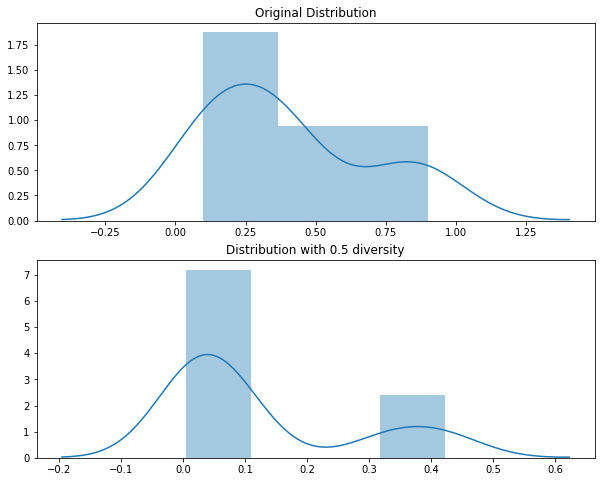

In [34]:
_ = diversify([0.1, 0.2, 0.4, 0.8, 0.9, 0.1, 0.3, 0.4], 0.5, plot = True)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


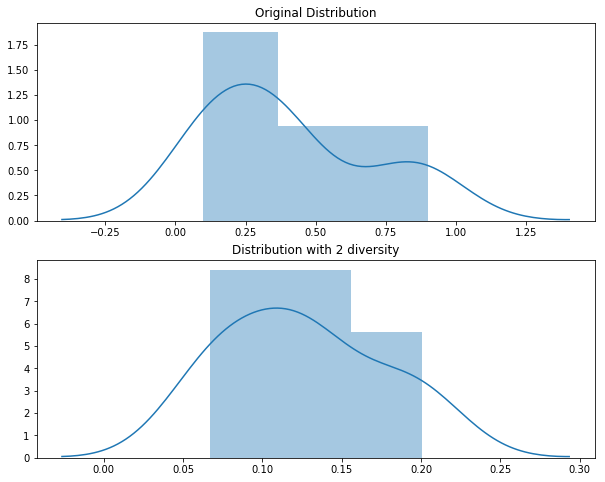

In [35]:
_ = diversify([0.1, 0.2, 0.4, 0.8, 0.9, 0.1, 0.3, 0.4], 2, plot = True)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


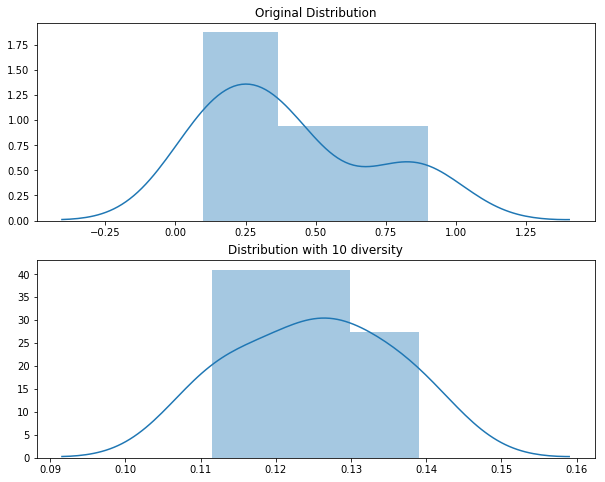

In [36]:
_ = diversify([0.1, 0.2, 0.4, 0.8, 0.9, 0.1, 0.3, 0.4], 10, plot = True)